# Phosphoproteomic aberrations associated with molecular signatures

In [35]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings
from sklearn.linear_model import LogisticRegressionCV   
from msresist.figures.figureM1 import filter_NaNpeptides
from msresist.logistic_regression import plotClusterCoefficients, plotPredictionProbabilities, plotConfusionMatrix, plotROC
from sklearn.cross_decomposition import PLSRegression

sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

## Import and Preprocess Data

In [2]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]

# filter peptides with excessive missingness
X_f = filter_NaNpeptides(X, cut=0.1)
X_f.index = np.arange(X_f.shape[0])
d_f = X_f.select_dtypes(include=['float64']).T
i_f = X_f.select_dtypes(include=['object'])

X_f.head()

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,C3N.02423,C3N.02423.N,C3N.02729,C3N.02729.N,C3L.00263,...,C3N.00738,C3N.00738.N,C3N.00959,C3N.00959.N,C3N.02003,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N
0,AAAAAsQQGSA,NP_001308122.1,TBL1XR1,S119-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071547,-0.600298,0.172339,-1.761406,0.421872,-0.372907,-0.979491,-0.083036,-0.361962,1.275506,-0.568015,0.25423,-0.378522,0.987749,-0.189486
1,AAAAGsASPRS,NP_064520.2,WRNIP1,S151-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAGsGPSPP,NP_060895.1,PI4K2A,S44-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83783,-0.993838,0.317079,...,0.031572,-0.554645,-0.033640,-1.268642,0.266790,-0.063300,-0.647500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAGsGPsPP,NP_060895.1,PI4K2A,S44-p;S47-p,0.477744,-1.231926,-1.600599,-1.349858,0.388473,-0.649326,0.394909,-1.041745,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAPsPGSAR,NP_036253.2,CDC42EP4,S292-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load Clustering Model from Figure 2

In [3]:
ncl = 15
with open('CPTACmodel_PAM250_W0075_15CL', 'rb') as f:
    MSC = pickle.load(f)[0]

## Regression against mutation status of driver genes and clusters

#### Import mutation status of TP53, KRAS, EGFR, and ALK fusion 

In [4]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv")
mOI = mutations[["Sample.ID", "TP53.mutation.status", "KRAS.mutation.status", "EGFR.mutation.status", "ALK.fusion"]]
mOI = mOI[~mOI["Sample.ID"].str.contains("IR")]

#### Import clusters

In [5]:
centers = MSC.transform(d_f)
centers["Patient_ID"] = X.columns[4:]
assert list(mOI["Sample.ID"]) == list(centers["Patient_ID"]), "Patients don't match"

x, y = centers.set_index("Patient_ID"), mOI.set_index("Sample.ID")

### PLSR model

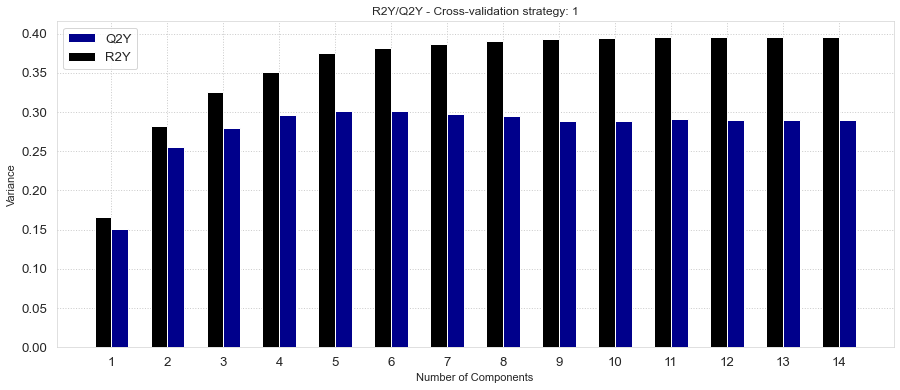

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plsr = PLSRegression(n_components=2)
plotR2YQ2Y(ax, plsr, x, y.iloc[:, [0, 2]], 1, ncl)

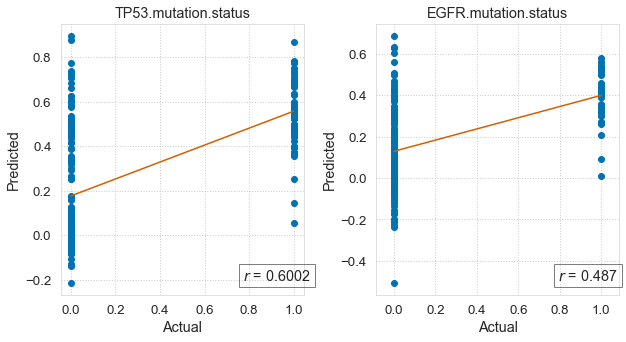

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, PLSRegression(n_components=4), x, y.iloc[:, [0, 2]], 2, y_pred="cross-validation")

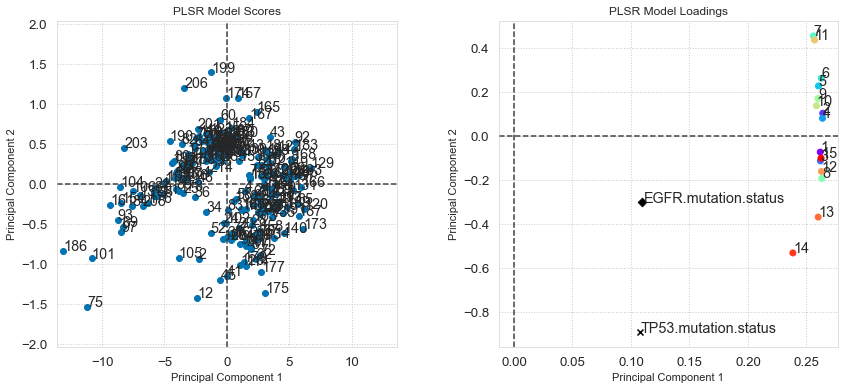

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, PLSRegression(n_components=4, scale=True).fit(x, y.iloc[:, [0, 2]]), x, y.iloc[:, [0, 2]], ncl, centers.index, cv=1, annotate=True)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

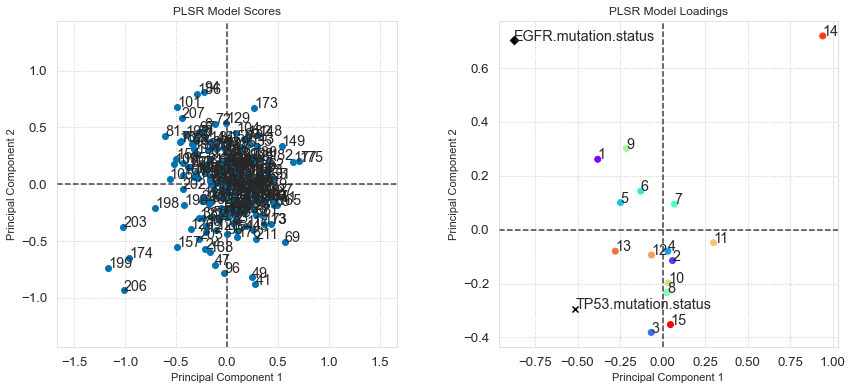

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, PLSRegression(n_components=4, scale=True).fit(x, y.iloc[:, [0, 2]]), x, y.iloc[:, [0, 2]], ncl, centers.index, cv=1, pcX=3, pcY=4, annotate=True)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

In [14]:
X_f["Cluster"] = MSC.labels_

In [34]:
X_f[X_f["Gene"] == "EGFR"]

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,C3N.02423,C3N.02423.N,C3N.02729,C3N.02729.N,C3L.00263,...,C3N.00738.N,C3N.00959,C3N.00959.N,C3N.02003,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N,Cluster
358,AENAEyLRVAP,NP_001333828.1,EGFR,Y1197-p,0.381003,-1.079347,-1.280693,-0.891470,0.016701,-0.523232,0.917233,-1.237335,1.589165,-1.054877,-0.712184,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.036784,-2.171377,-0.977998,-0.740584,-0.308504,-1.346013,-0.497538,-1.358546,1
4736,EPLTPsGEAPN,NP_001333828.1,EGFR,S695-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
8538,IKVLGsGAFGT,NP_001333828.1;NP_001005862.1,EGFR,S720-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.098993,1.649269,-1.144398,0.193207,-0.568270,-0.453623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
10959,LDNPDyQQDFF,NP_001333828.1,EGFR,Y1172-p,0.424011,-0.953394,-1.006670,-0.321717,-0.145199,-0.931119,0.915072,-1.303925,2.072982,-1.419678,-0.477420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
11852,LLSSLsATSNN,NP_001333828.1,EGFR,S1039-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
11853,LLSSLsATsNN,NP_001333828.1,EGFR,S1039-p;S1042-p,0.429360,-1.321256,-0.828027,-1.422947,0.364454,-0.447976,0.327451,-0.371574,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
11854,LLSSLsAtSNN,NP_001333828.1,EGFR,S1039-p;T1041-p,0.429360,-1.321256,-0.828027,-1.422947,0.364454,-0.447976,0.327451,-0.371574,NaN,NaN,NaN,...,-0.175460,0.318698,-1.684287,-0.339035,0.152987,-0.814586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
12160,LPVPEyINQSV,NP_001333828.1,EGFR,Y1092-p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.967207,-0.379033,-1.932658,-0.023449,-1.350884,-1.203253,-0.770842,-1.409362,0.833030,-0.389102,-0.149543,-0.975485,-0.247661,-0.877243,1
12956,LVEPLtPSGEA,NP_001333828.1,EGFR,T693-p,-0.181453,-0.924836,-1.047397,-0.418503,0.286382,-0.283570,1.199248,0.135548,0.782249,-0.813652,-0.281927,...,-0.572037,-0.092625,-1.336403,-0.462218,-0.870157,-0.435875,0.075468,-0.147185,-0.780913,0.620966,0.462047,0.428509,0.057541,0.009685,14
15031,PIKEDsFLQRY,NP_001333828.1,EGFR,S1064-p,-0.730168,-1.937529,-2.528583,-0.596243,0.291057,-0.646607,1.123397,-2.232979,1.807625,-3.267094,-1.026181,...,-1.600741,-1.136667,-4.060308,-0.464541,-2.471656,-3.222059,1.179752,-2.355870,-0.177808,-1.500876,-0.382806,-1.677158,0.544637,-0.801830,12


### Logistic Regression

EGFR mutation status

In [111]:
c = centers.iloc[:, :-1]
y_egfr = y["EGFR.mutation.status"]

lr = LogisticRegressionCV(cv=ncl, solver="saga", penalty="l1", class_weight={0:0.56, 1:0.80}).fit(c, y_egfr)
y_pred = lr.predict(c)

lr_score = lr.score(c, y_egfr)
print("LR prediction score: ", lr_score)

LR prediction score:  0.8744186046511628


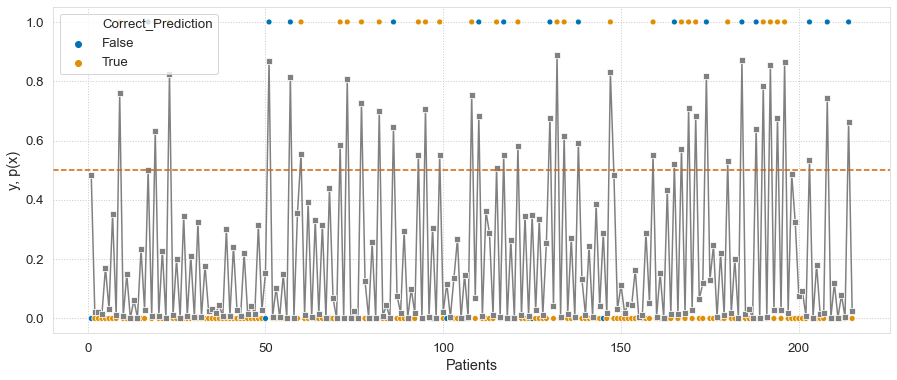

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plotPredictionProbabilities(ax, lr, y_pred, c, y_efgr)

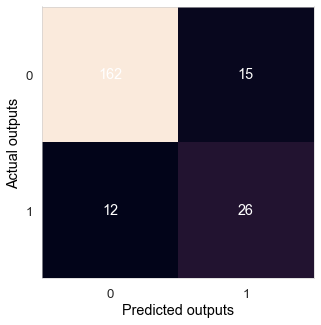

In [113]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, lr, c, y_egfr)

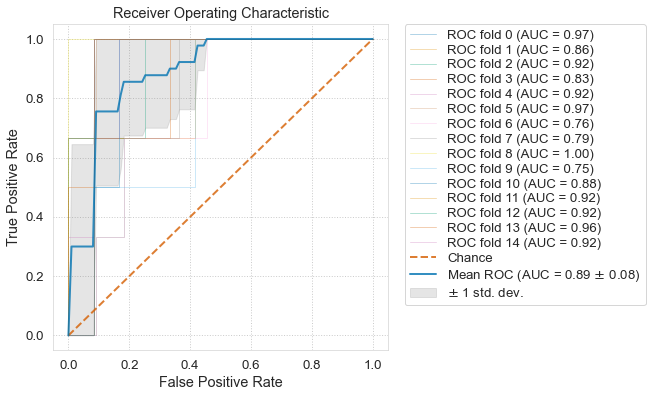

In [114]:
fig, ax = plt.subplots(figsize=(6, 6))
plotROC(ax, lr, c, y_egfr, cv_folds=ncl)

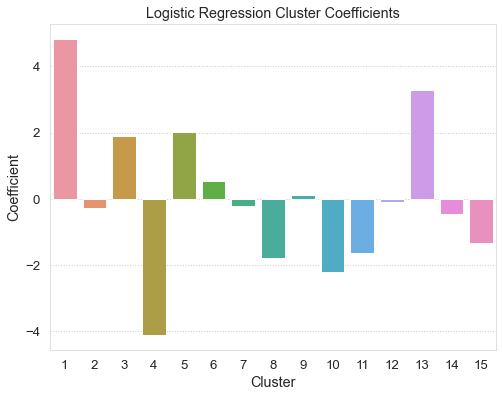

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, lr)

TP53 mutation status

In [154]:
from sklearn.linear_model import LogisticRegressionCV
c = centers.iloc[:, :-1]
y_tp53 = y["TP53.mutation.status"]

lr = LogisticRegressionCV(cv=ncl, solver="saga", penalty="l1", class_weight={0:0.65, 1:0.9})bb.fit(c, y_tp53)
y_pred = lr.predict(c)

lr_score = lr.score(c, y_tp53)
print("LR prediction score: ", lr_score)

LR prediction score:  0.8325581395348837


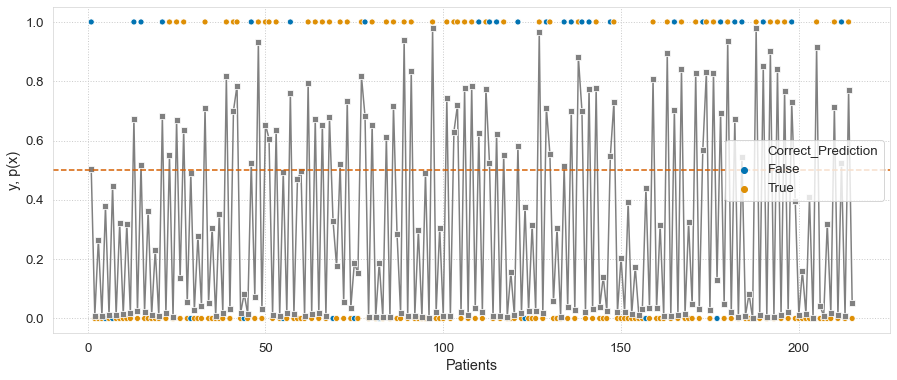

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plotPredictionProbabilities(ax, lr, y_pred, c, y_tp53)

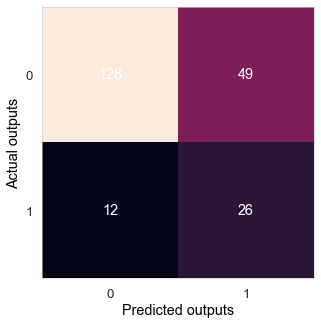

In [156]:
fig, ax = plt.subplots(figsize=(5, 5))
plotConfusionMatrix(ax, lr, c, y_egfr)

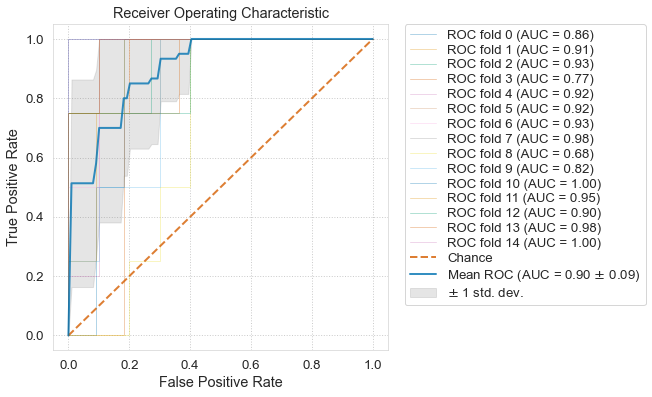

In [157]:
fig, ax = plt.subplots(figsize=(6, 6))
plotROC(ax, lr, c, y_tp53, cv_folds=ncl)

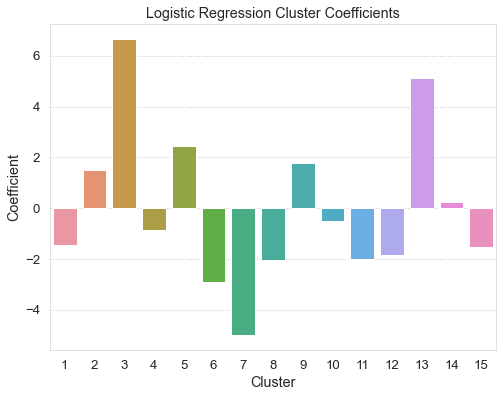

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plotClusterCoefficients(ax, lr)